<a href="https://colab.research.google.com/github/eunzzae/Study_DS/blob/main/24)_%ED%98%B8%ED%85%94_%EC%98%88%EC%95%BD_%EC%88%98%EC%9A%94_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 호텔 예약 수요 분석
>**목차**

* 문제상황 및 데이터 살펴보기
* 문제해결 프로세스 정의  
1) 월 별 예약 수요 분석  
2) 취소고객, 노쇼 고객 분석  
3) ML 활용 취소/노쇼 고객 예측

In [1]:
# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

# ▶ Google drive mount or 폴더 클릭 후 구글드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

# # ▶ 경로 설정 (※ Colab을 활성화시켰다면 보통 Colab Notebooks 폴더가 자동 생성)
# import os
# os.chdir('/content/drive/MyDrive/Colab Notebooks/part3_lecture_fastcampus/chapter23')
# # '/content/drive/MyDrive/Colab Notebooks/ ← 여기 경로까지는 본인의 경로 입력, part3_lecture_fastcampus/chapter23' ← 변경X
# os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 문제상황 및 데이터 살펴보기
---
> **시나리오** 🏨🔖 (예약관리자(팀))

```
A호텔은 요즘 코로나 여파로 인하여 고생을 겪고 있다. 객실 예약 건수도 줄고 있는 마당에 노쇼/취소 고객도 증가있는 것이 가장 큰 문제이다.  
캔슬 고객은 그나마 다행이지만 노쇼 고객의 경우 객실을 하루 날려버리는 것과 같아서, 비용적인 문제에서도 큰 영향을 끼치고 있다. 따라서 노쇼와  
취소고객을 사전 예측하고, 운영 비용을 상황에 맞춰 조정하려고 한다.

```  

> **데이터 살펴보기**

* 호텔 예약 발생 데이터
* 데이터 명세 ⬇

|hotel|is_canceled|lead_time|arrival_date_year|arrival_date_month|arrival_date_week_number|
|:---:|:---:|:---:|:---:|:---:|:---:|
|호텔명|취소여부|입실까지 남은일|년|월|일|
|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|children|babies|
|일|주말여부|평일여부|성인|어린이|영유아|
|meal|country|market_segment|distribution_channel|is_repeated_guest|previous_cancellations|
|식사|나라|예약유통채널상세|예약유통채널|기존고객여부|과거 취소한 예약수|
|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_changes|deposit_type|agent|
|과거 취소하지않은 예약수|예약객실타입|배정된객실타입|예약변경횟수|보증금여부|여행사ID|
|company|days_in_waiting_list|customer_type|adr|required_car_parking_spaces|total_of_special_requests|
|예약지불회사|대기자 명단에 있었던 일수|계약타입|평균객실비용|요구주차대수|특별요청수|
|reservation_status|reservation_status_date|
|예약상태|예약상태 업데이트 날짜|


In [2]:
# Data read
import pandas as pd
bath = '/content/drive/MyDrive/[STUDY] 데이터사이언스/데이터분석/data/chapter24_호텔 예약 수요 분석/'
df = pd.read_csv(bath + 'chapter24_hotel_bookings.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03



## **문제해결 프로세스 정의**
---
> **문제정의**

```
노쇼/취소 고객 증가로 인한 영업이익 감소
```  

> **기대효과**

```
노쇼/취소 고객 손실 비용 절감, 영업이익 증가
```

> **해결방안**

```
노쇼/취소 고객 예측 모델로 고객을 예측하고, 운영 비용 조정
Session 1
 - Data 전처리 및 객실 수요 파악
Session 2
 - 취소 및 노쇼 비율 현황 파악 및 고객 특성별 취소/노쇼율 분석
Session 3
 - ML 알고리즘을 활용하여 취소/노쇼 고객 예측
```

> **성과측정**  

```
모델 활용 노쇼/취소 고객 관리 전/후 손실비용 비교
```

> **현업적용**  

```
Model에 Input하기 위한 Data mart 생성
예측 모델 활용 노쇼/취소 고객 추출
노쇼/취소 가능성이 높은 객실에 대해서는 다른 예약손님을 대체할 수 있도록 준비
```

> **주요 코드 미리 살펴보기**  

```
session 1 → fillna(0), replace, sns.barplot(order=[''])
session 2 → np.where, catplot, groupby.agg()
session 3 → RandomForestClassifier(), LabelEncoder(), roc_auc_score, roc_curve
```

## Session 1
## 월 별 예약 수요 분석

### Data 전처리
---

In [3]:
# Data shape
# 119,390 row, 32 col
print('df', df.shape)

df (119390, 32)


In [4]:
# Data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [5]:
# null 확인
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [6]:
# outlier 확인
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


In [7]:
# 0이나 none으로 해석될 수 있는 것은 채워 넣는다.
df['children'].fillna(0, inplace=True)
df['country'].fillna('none', inplace=True)
df['agent'].fillna(0, inplace=True)
df['company'].fillna(0, inplace=True)

In [8]:
df.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                         

In [9]:
# 음수값 제거
# 119390row, 32col -> 117430row, 32col
df = df[df['adr']>0]

In [10]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,117430.000000,117430.000000,117430.000000,117430.000000,117430.000000,117430.000000,117430.000000,117430.000000,117430.000000,117430.000000,117430.000000,117430.000000,117430.000000,117430.000000,117430.000000,117430.00000,117430.000000,117430.000000,117430.000000,117430.000000
mean,0.374785,105.084340,2016.160274,27.136779,15.802819,0.936422,2.521221,1.860632,0.104505,0.007869,0.027872,0.086954,0.125334,0.216486,75.177348,10.54716,2.337937,103.530818,0.062642,0.571038
std,0.484069,106.907012,0.706565,13.575680,8.783582,0.995760,1.893742,0.482102,0.399690,0.097168,0.164607,0.848690,1.446204,0.633188,107.235820,53.54574,17.677053,49.198721,0.245565,0.791655
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.260000,0.000000,0.000000
25%,0.000000,19.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.00000,0.000000,70.530000,0.000000,0.000000
50%,0.000000,71.000000,2016.000000,27.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.00000,0.000000,95.000000,0.000000,0.000000
75%,1.000000,162.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,154.000000,0.00000,0.000000,126.000000,0.000000,1.000000
max,1.000000,709.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,4.000000,10.000000,10.000000,1.000000,26.000000,72.000000,18.000000,535.000000,543.00000,391.000000,5400.000000,8.000000,5.000000


### 객실 수요 파악
---

In [11]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,0.0,0.0,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,0.0,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,0.0,0,Transient,98.0,0,1,Check-Out,2015-07-03
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,0.0,0,Transient,98.0,0,1,Check-Out,2015-07-03
6,Resort Hotel,0,0,2015,July,27,1,0,2,2,...,No Deposit,0.0,0.0,0,Transient,107.0,0,0,Check-Out,2015-07-03


In [12]:
# 년도별 객실 예약 현황
df['arrival_date_year'].value_counts()

arrival_date_year
2016    55789
2017    40231
2015    21410
Name: count, dtype: int64

In [13]:
# 월별 객실 예약 현황
df['arrival_date_month'].value_counts()

arrival_date_month
August       13711
July         12491
May          11611
April        10953
October      10929
June         10819
September    10351
March         9641
February      7921
November      6641
December      6561
January       5801
Name: count, dtype: int64

In [14]:
# 년, 월별 객실 이용 현황
df_reservation = pd.DataFrame(df.groupby(['arrival_date_year','arrival_date_month'], as_index=False)['hotel'].count())
df_reservation.head(10)

,arrival_date_year,arrival_date_month,hotel
0,2015,August,3794
1,2015,December,2795
2,2015,July,2714
3,2015,November,2274
4,2015,October,4824
5,2015,September,5009
6,2016,April,5346
7,2016,August,5020
8,2016,December,3766
9,2016,February,3820


In [15]:
df_reservation = df_reservation.replace({'January' : '01.January',
                                         'February' : '02.February',
                                         'March' : '03.March',
                                         'April' : '04.April',
                                         'May' : '05.May',
                                         'June' : '06.June',
                                         'July' : '07.July',
                                         'August' : '08.August',
                                         'September' : '09.September',
                                         'October' : '10.October',
                                         'November' : '11.November',
                                         'December' : '12.December'})
df_reservation.head()

,arrival_date_year,arrival_date_month,hotel
0,2015,08.August,3794
1,2015,12.December,2795
2,2015,07.July,2714
3,2015,11.November,2274
4,2015,10.October,4824


In [16]:
# 년, 월 sorting, 2015년은 7월~12월 데이터 존재, 2016년 1월~12월 데이터 존재, 2017년 1월~8월까지 데이터 존재
# Plotting 어려움
df_reservation.sort_values(by=['arrival_date_year', 'arrival_date_month'])

,arrival_date_year,arrival_date_month,hotel
2,2015,07.July,2714
0,2015,08.August,3794
5,2015,09.September,5009
4,2015,10.October,4824
3,2015,11.November,2274
1,2015,12.December,2795
10,2016,01.January,2183
9,2016,02.February,3820
13,2016,03.March,4739
6,2016,04.April,5346


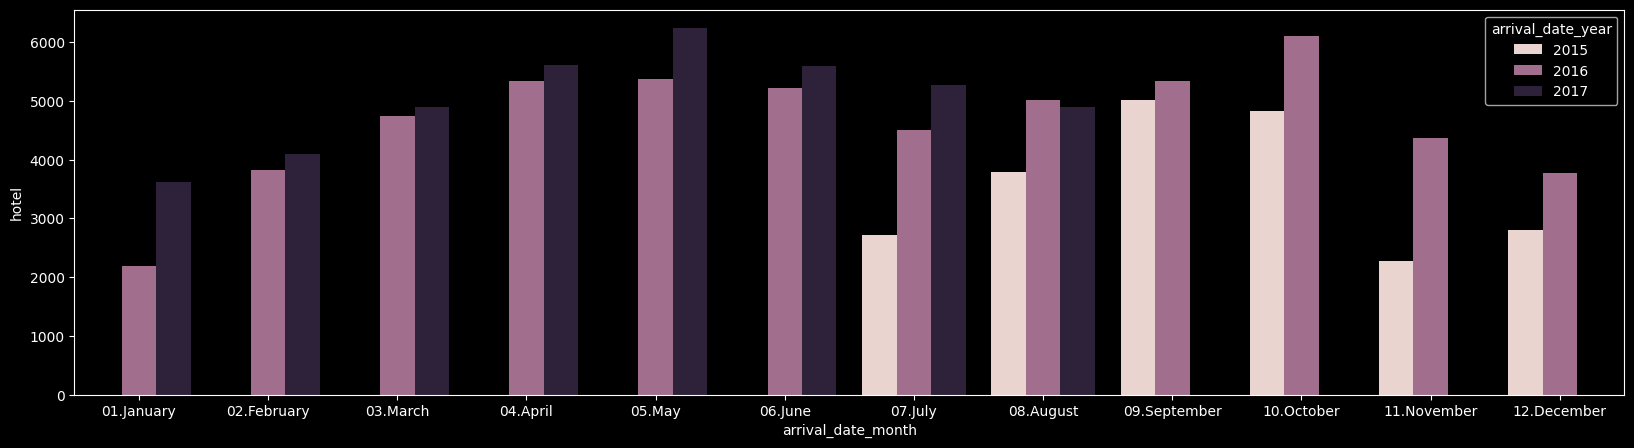

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

sns.barplot(x='arrival_date_month', y='hotel', hue='arrival_date_year', data=df_reservation,
            order=['01.January', '02.February', '03.March','04.April', '05.May', '06.June', '07.July', '08.August', '09.September', '10.October', '11.November', '12.December'])
plt.gcf().set_size_inches(20, 5)

## Session 2
## 취소고객, 노쇼고객 분석


### 취소 및 노쇼 비율
---

In [18]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,0.0,0.0,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,0.0,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,0.0,0,Transient,98.0,0,1,Check-Out,2015-07-03
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,0.0,0,Transient,98.0,0,1,Check-Out,2015-07-03
6,Resort Hotel,0,0,2015,July,27,1,0,2,2,...,No Deposit,0.0,0.0,0,Transient,107.0,0,0,Check-Out,2015-07-03


In [19]:
df['reservation_status'].value_counts()

reservation_status
Check-Out    73419
Canceled     42830
No-Show       1181
Name: count, dtype: int64

In [20]:
# 취소 비율
print('Canceled :', 42830/(73419+42830+1181))

# 노쇼 비율
print('No-Show :', 1181/(73419+42830+1181))

Canceled : 0.36472792301796814
No-Show : 0.010057055266967554


In [21]:
# 취소 노쇼에 대한 데이터 1로 변경
import numpy as np
df['reservation_status'] = np.where(df['reservation_status'] != 'Check-Out', 1, 0)
df['reservation_status'].value_counts()

reservation_status
0    73419
1    44011
Name: count, dtype: int64

In [22]:
44011/ (73419+44011)

0.37478497828493573

취소 및 노쇼 고객 특성 분석
---

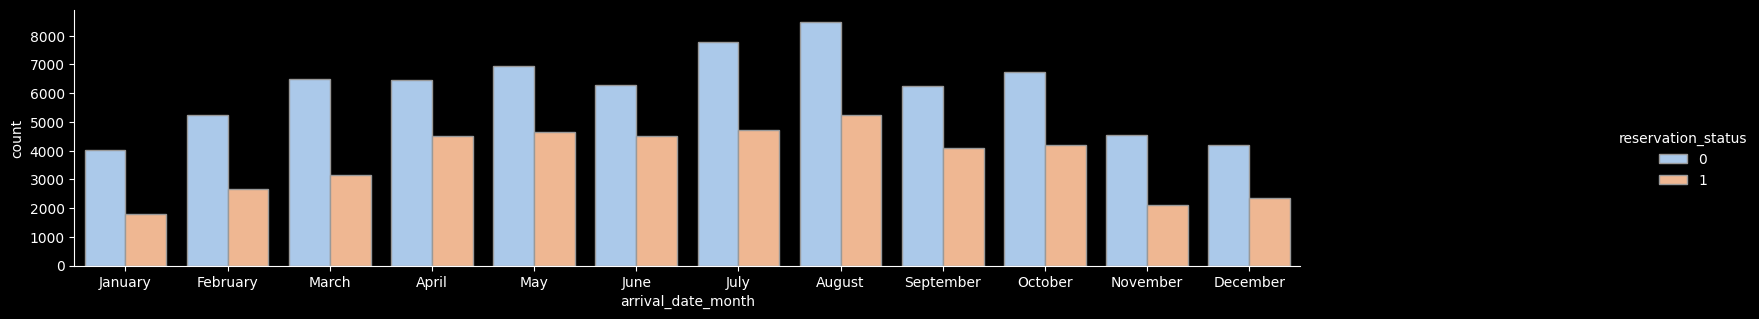

In [23]:
# 월에 따른 취소/노쇼율 비교
sns.catplot(x='arrival_date_month', hue='reservation_status', kind='count', palette='pastel', edgecolor='.6', data=df,
            order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.gcf().set_size_inches(20, 3)

In [24]:
# 월에 따른 취소/노쇼율 비교
df_gp = df.groupby('arrival_date_month')['reservation_status'].agg(['count', 'sum'])
df_gp['ratio'] = round((df_gp['sum']/df_gp['count'])*100, 1)
df_gp = df_gp.sort_values(by=['ratio'], ascending=False)
df_gp

,count,sum,ratio
arrival_date_month,,,
June,10819,4523,41.8
April,10953,4504,41.1
May,11611,4659,40.1
September,10351,4092,39.5
October,10929,4209,38.5
August,13711,5228,38.1
July,12491,4723,37.8
December,6561,2355,35.9
February,7921,2676,33.8


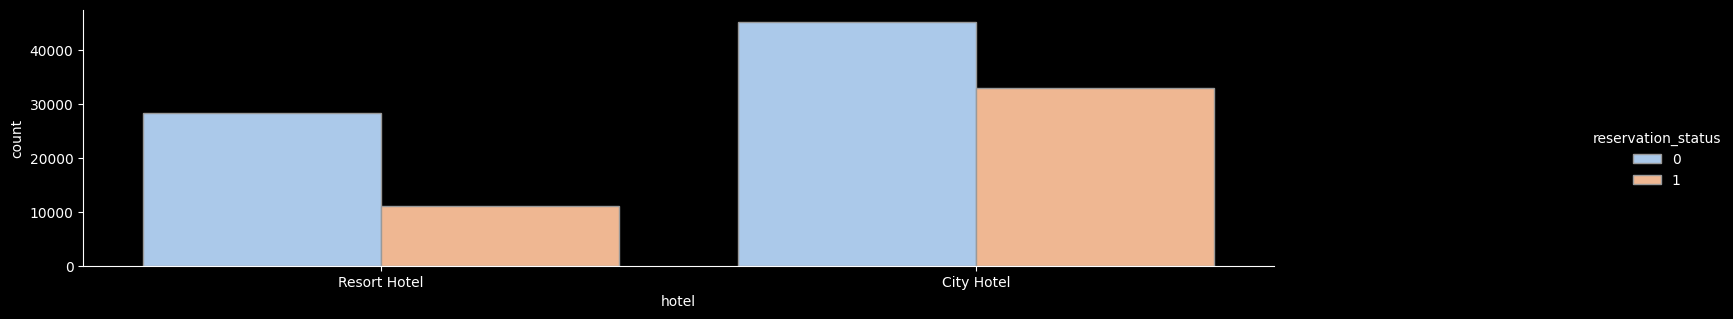

In [25]:
# 호텔별 비교(resort hotel과 city hotel)
sns.catplot(x='hotel', hue='reservation_status', kind='count',palette='pastel', edgecolor='.6', data=df)
plt.gcf().set_size_inches(20, 3)

In [26]:
# 호텔별 비교(resort hotel과 city hotel)
df_gp = df.groupby('hotel')['reservation_status'].agg(['count', 'sum'])
df_gp['ratio'] = round((df_gp['sum']/df_gp['count'])*100, 1)
df_gp = df_gp.sort_values(by=['ratio'], ascending=False)
df_gp

,count,sum,ratio
hotel,,,
City Hotel,78122,32973,42.2
Resort Hotel,39308,11038,28.1


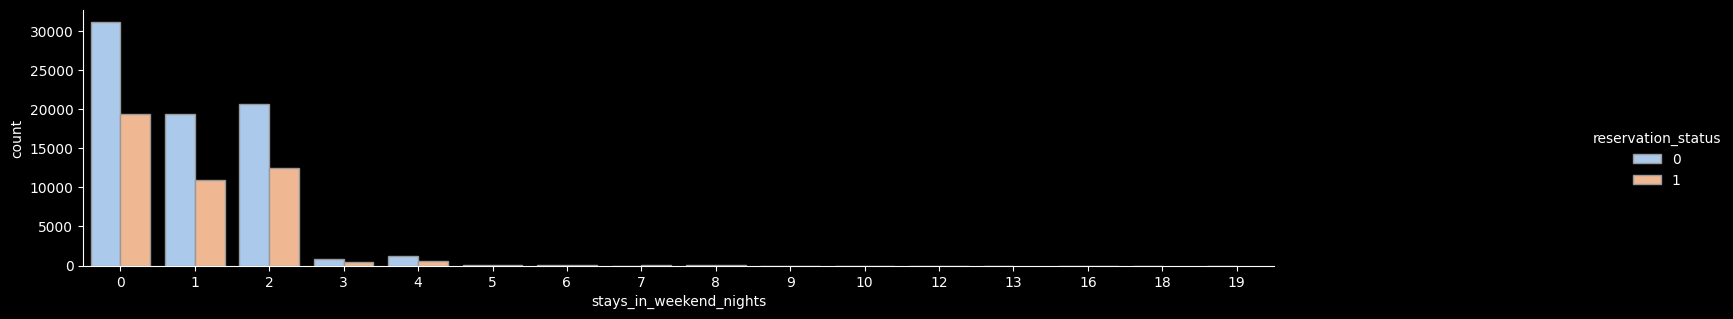

In [27]:
# 주말 예약 일수에 따른 비교
sns.catplot(x='stays_in_weekend_nights', hue='reservation_status', kind='count',palette='pastel', edgecolor='.6', data=df)
plt.gcf().set_size_inches(20, 3)

In [28]:
# 주말 예약 일수에 따른 비교
df_gp = df.groupby('stays_in_weekend_nights')['reservation_status'].agg(['count', 'sum'])
df_gp['ratio'] = round((df_gp['sum']/df_gp['count'])*100, 1)
df_gp = df_gp.sort_values(by=['ratio'], ascending=False)
df_gp

,count,sum,ratio
stays_in_weekend_nights,,,
9,9,7,77.8
7,19,14,73.7
8,57,34,59.6
6,152,87,57.2
5,77,43,55.8
0,50499,19361,38.3
2,33150,12453,37.6
1,30361,10967,36.1
3,1244,444,35.7


<Axes: xlabel='stays_in_weekend_nights', ylabel='Density'>

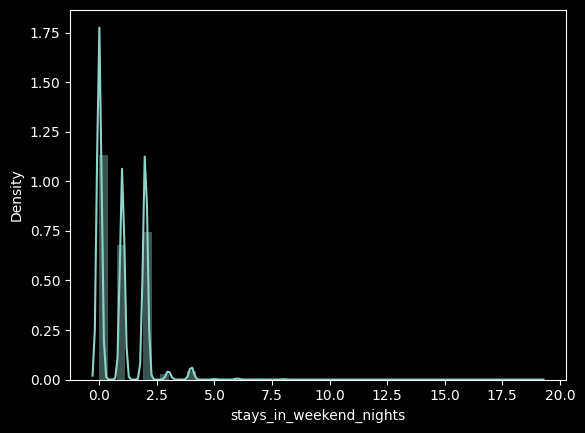

In [29]:
sns.distplot(df['stays_in_weekend_nights'])

In [30]:
# 주말 예약 일수에 따른 비교(re-binning)
df_c = df.copy()

df_c['gp'] = np.where(df_c['stays_in_weekend_nights'] <= 2, 1,
                      np.where(df_c['stays_in_weekend_nights'] <= 8, 2, 3))

df_gp = df_c.groupby('gp')['reservation_status'].agg(['count', 'sum'])
df_gp['ratio'] = round((df_gp['sum']/df_gp['count'])*100, 1)
df_gp = df_gp.sort_values(by=['ratio'], ascending=False)
df_gp

,count,sum,ratio
gp,,,
3,27,11,40.7
1,114010,42781,37.5
2,3393,1219,35.9


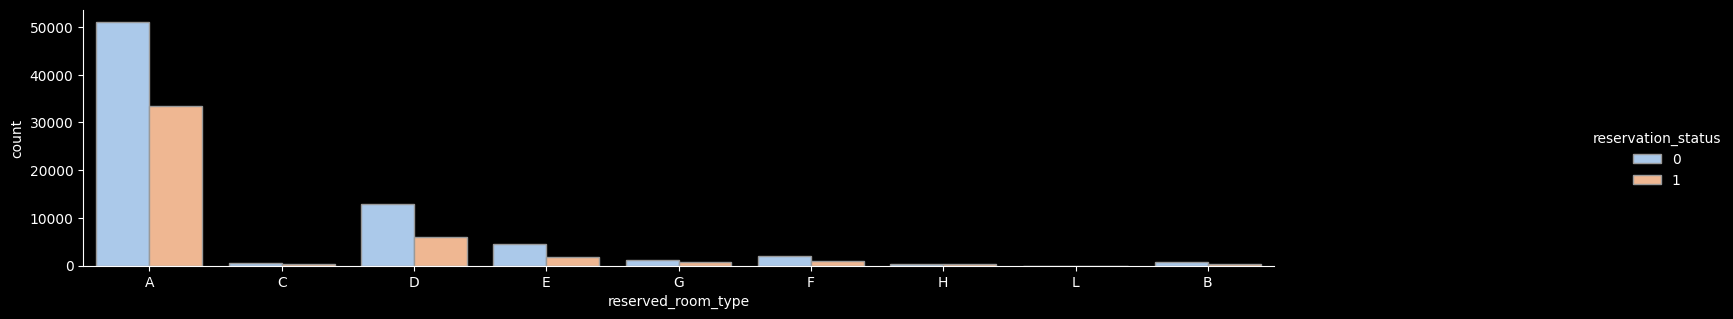

In [31]:
# 객실 타입에 따른 비교
sns.catplot(x='reserved_room_type', hue='reservation_status', kind='count', palette='pastel', edgecolor='.6', data=df)
plt.gcf().set_size_inches(20, 3)

In [32]:
# 객실 타입에 따른 비교
df_gp = df.groupby('reserved_room_type')['reservation_status'].agg(['count', 'sum'])
df_gp['ratio']=round((df_gp['sum']/df_gp['count'])*100, 1)
df_gp = df_gp.sort_values(by=['ratio'], ascending=False)
df_gp

,count,sum,ratio
reserved_room_type,,,
H,595,245,41.2
A,84573,33477,39.6
G,2006,756,37.7
B,1085,365,33.6
C,913,306,33.5
L,6,2,33.3
D,19005,6086,32.0
F,2824,873,30.9
E,6423,1901,29.6


<Axes: xlabel='lead_time', ylabel='Density'>

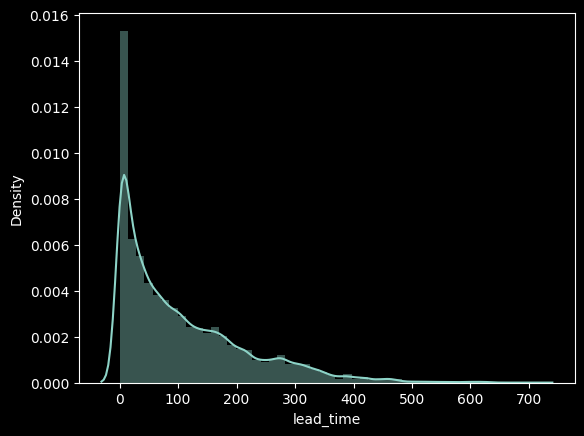

In [33]:
# lead time
sns.distplot(df['lead_time'])

In [34]:
# lead time 구간화
df_c = df.copy()
df_c['gp']=np.where(df_c['lead_time'] <=100, 1,
                    np.where(df_c['lead_time']<=200, 2, 3))

df_gp = df_c.groupby('gp')['reservation_status'].agg(['count', 'sum'])
df_gp['ratio']=round((df_gp['sum']/df_gp['count'])*100, 1)
df_gp = df_gp.sort_values(by=['ratio'],ascending=False)
df_gp

,count,sum,ratio
gp,,,
3,20526,12182,59.3
2,26586,11987,45.1
1,70318,19842,28.2


## Session 3
## ML 활용 취소/노쇼 고객 예측

### 모델링을 위한 데이터 준비
---

In [35]:
# numeric, categorical value 나누기
numeric_list = []
categorical_list = []
for col in df.columns:
  if df[col].dtype != 'object':
    numeric_list.append(col)
  else:
    categorical_list.append(col)

print('categorical_list :', categorical_list)
print('numeric_list :', numeric_list)

categorical_list : ['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status_date']
numeric_list : ['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'agent', 'company', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'reservation_status']


In [36]:
# Feature(X)와 Y 데이터 구분
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

X=df.drop(['is_canceled', 'reservation_status_date', 'reservation_status'], axis=1)
Y=df['reservation_status']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(82201, 29)
(82201,)
(35229, 29)
(35229,)


In [37]:
categorical_list.remove('reservation_status_date')

In [38]:
from sklearn.preprocessing import LabelEncoder

for col in categorical_list:
    print(col)
    le = LabelEncoder()
    le.fit(list(x_train[col].values) + list(x_test[col].values))
    x_train[col] = le.transform(x_train[col])
    x_test[col] = le.transform(x_test[col])

hotel
arrival_date_month
meal
country
market_segment
distribution_channel
reserved_room_type
assigned_room_type
deposit_type
customer_type


In [39]:
x_test[categorical_list].head()

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type
91329,0,6,0,12,5,3,0,0,0,3
101619,0,9,0,59,2,0,0,0,0,2
21031,1,3,0,59,6,3,0,0,0,2
31556,1,2,2,135,4,1,4,4,0,3
65905,0,0,0,54,6,3,4,4,0,2


### 모델 학습 및 평가
---

In [40]:
# 학습
from sklearn.metrics import classification_report
rfc = RandomForestClassifier(random_state = 123456, max_depth=6)
rfc.fit(x_train, y_train)

# 예측
y_pred_train = rfc.predict(x_train)
y_pred_test = rfc.predict(x_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.74      0.99      0.85     51393
           1       0.98      0.42      0.59     30808

    accuracy                           0.78     82201
   macro avg       0.86      0.71      0.72     82201
weighted avg       0.83      0.78      0.75     82201

              precision    recall  f1-score   support

           0       0.74      0.99      0.85     22026
           1       0.98      0.42      0.59     13203

    accuracy                           0.78     35229
   macro avg       0.86      0.71      0.72     35229
weighted avg       0.83      0.78      0.75     35229



In [41]:
# 과적합 문제, Train과 Test set에 성능을 최대한 줄여줌으로써 과적합 방지
from sklearn.metrics import roc_auc_score

y_pred_train_proba = rfc.predict_proba(x_train)[:,1]
y_pred_test_proba = rfc.predict_proba(x_test)[:, 1]


roc_score_train = roc_auc_score(y_train, y_pred_train_proba)
roc_score_test = roc_auc_score(y_test, y_pred_test_proba)

print("roc_score_train :", roc_score_train)
print("roc_score_test :", roc_score_test)

roc_score_train : 0.9096714798626395
roc_score_test : 0.9091041827076782


In [42]:
from sklearn.metrics import roc_curve
def roc_curve_plot(y_test , pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환 받음.
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1)

    # ROC Curve를 plot 곡선으로 그림.
    plt.plot(fprs , tprs, label='ROC')
    # 가운데 대각선 직선을 그림.
    plt.plot([0, 1], [0, 1], 'k--', label='Random', color='red')

    # FPR X 축의 Scale을 0.1 단위로 변경, X,Y 축명 설정등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )')
    plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()

### 중요변수 파악
---

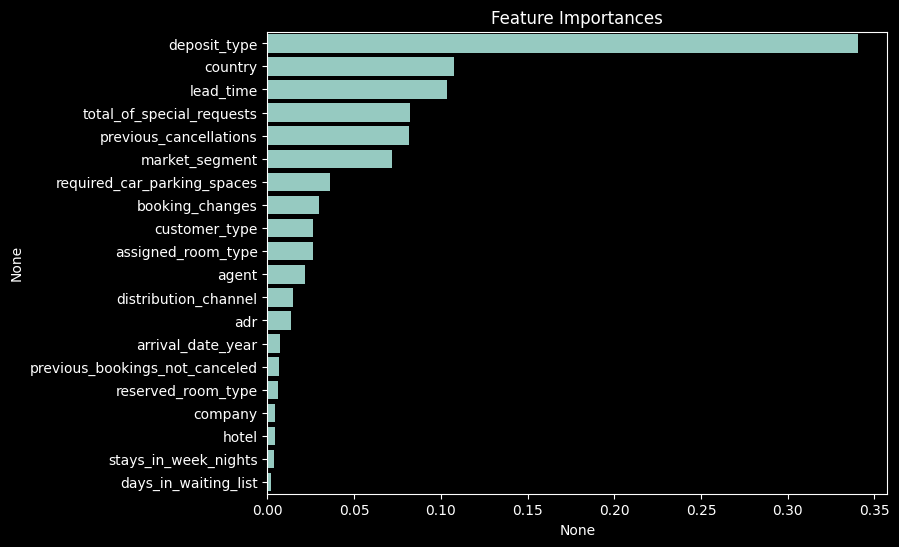

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

ftr_importances_values = rfc.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = x_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
# plt.rc('xtick', labelsize=5)
plt.show()

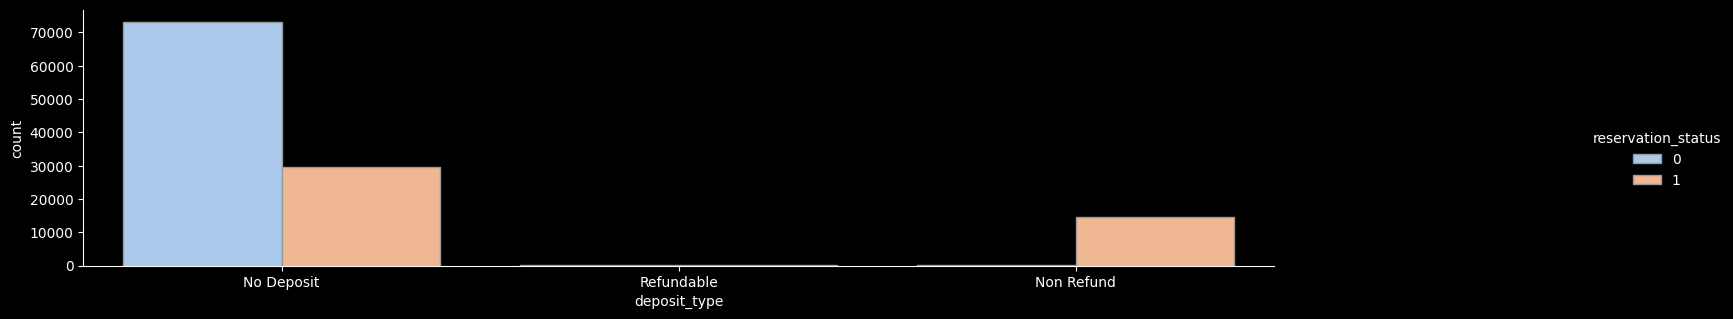

In [45]:
# 후보 1위 변수 탐색
sns.catplot(x='deposit_type', hue='reservation_status', kind='count', palette='pastel', edgecolor='.6', data=df)
plt.gcf().set_size_inches(20, 3)

In [47]:
# 월에 따른 취소/노쇼율 비교
df_gp = df.groupby('deposit_type')['reservation_status'].agg(['count', 'sum'])
df_gp['ratio']=round((df_gp['sum']/df_gp['count'])*100, 1)
df_gp = df_gp.sort_values(by=['ratio'], ascending=False)
df_gp

,count,sum,ratio
deposit_type,,,
Non Refund,14587,14494,99.4
No Deposit,102681,29481,28.7
Refundable,162,36,22.2


In [49]:
# country
df_gp = df.groupby(by='country')['reservation_status'].agg(['count', 'sum'])
df_gp['ratio']=round((df_gp['sum']/df_gp['count'])*100, 1)
df_gp = df_gp.sort_values(by=['ratio'], ascending=False)
df_gp[df_gp['count']>2000]

,count,sum,ratio
country,,,
PRT,47040,27332,58.1
BRA,2211,829,37.5
ITA,3749,1332,35.5
ESP,8489,2176,25.6
IRL,3369,832,24.7
USA,2086,500,24.0
GBR,12055,2451,20.3
BEL,2334,472,20.2
FRA,10360,1932,18.6


In [51]:
# total_of_special_requests
df_gp = df.groupby('total_of_special_requests')['reservation_status'].agg(['count', 'sum'])
df_gp['ratio']=round((df_gp['sum']/df_gp['count'])*100, 1)
df_gp = df_gp.sort_values(by=['ratio'], ascending=False)
df_gp

,count,sum,ratio
total_of_special_requests,,,
0,69140,33404,48.3
2,12763,2849,22.3
1,32727,7279,22.2
3,2436,442,18.1
4,324,35,10.8
5,40,2,5.0


### 모델 save and read
---

In [52]:
import pickle
# 모델 저장
saved_model = pickle.dumps(rfc)

# 모델 Read
clf_from_pickle = pickle.loads(saved_model)

In [53]:
# 4월 취소/노쇼 고객을 예측한다고 가정할 시
# 3월31일 기준으로 Data mart 생성
Data_mart_3월마감 = pd.read_csv("3월31일 마감.csv")

FileNotFoundError: [Errno 2] No such file or directory: '3월31일 마감.csv'

In [54]:
# predict(예측)
pred = clf_from_pickle.predict(Data_mart_3월마감)

NameError: name 'Data_mart_3월마감' is not defined

In [ ]:
# predict 데이터 3월 Data mart 데이터에 결합 후 노쇼/캔슬(1)에 해당하는 데이터 추출
Data_mart_3월마감['Y'] = pred
Data_mart_3월마감[Data_mart_3월마감['Y']==1]